# Discrete Choice Analysis: micro-econometrics and machine learning approaches

## `Lab session 1: Artificial Neural Networks`

**Delft University of Technology**<br>
**February 2024**<br>
**Instructor:** Sander van Cranenburgh <br>
**TAs:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Illustrate how models and theory discussed in the classroom work out in practice.
* Help you gather hands-on modelling and data analysis skills.

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

### `Workspace set-up`

**Option 1: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment, to install all dependencies on your Python version.

In [94]:
#!pip install -r requirements.txt

**Option 2: Google Colab**<br>
Uncomment the following cell if you are running this notebook on Colab

In [95]:
#!git clone https://github.com/DCM-ML-course-TRAIL/DCM_ML_TRAIL_2024
#!pip install -r DCM_ML_TRAIL_2024/requirements_colab.txt
#!mv "/content/DCM_ML_TRAIL_2024/Lab sessions/data" /content/data

# `Application: Modelling mode choices` <br>
In this lab session, we will analyse mode choice behaviour. Understanding people's preferences over transport attributes is crucial for city planners when they (re)develop  devise policies to enhance sustainable urban mobility. During this lab session, you will apply discrete choice models to uncover people's preferences over attributes, such as the travel time, travel cost, access time, and level of service. Also, you will explore whether preferences interact with covariates such as female, business, income. While doing so, you will test various utility specifications and interpret the modelling outcomes of discrete choice models.

For this study, we use data from a Stated Choice (SC) experiment provided by [Apollo](https://www.apollochoicemodelling.com/examples.html)

**`Learning objectives lab session 01`**

After completing the following exercises you will be able to: <br>
* Prepare (choice) data for training Artificial Neural Networks
* Train MultiLayerPerceptron (MLP) - a praticular type of neural network - for a classification task<br>
* Tune the hyperparameter and network architectures to improve the model performance<br>
* Assess the performance of of competing models, based on various performance measures, including confusion matrices, and Precision, Recall, F1 scores and Matthew's coefficient<br>


**`This lab consists of 6 parts`**
1. Preparing (choice) data for training Artificial Neural Networks
2. Training a MultiLayerPerceptron (MLP) neural network
3. Using Early stopping to avoid overfitting
4. Using k-fold cross validation to evaluate generalisation performance
5. Tuning hyperparameter
6. Evaluating performance of trained models

and comprises **`7`** exercises.

#### `Import packages`

To begin, we will import all the Python libraries that we will use in this lab session.

In [96]:
# Import required Python packages and modules
import os
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

# Import selected functions and classes from Python packages
from os import getcwd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, log_loss, matthews_corrcoef, make_scorer, classification_report

# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, log

# Setting
pd.set_option('display.max_columns', None)

### `0. Preparing (choice) data for training Artificial Neural Networks`
To prepare the data set, we will:<br>
    1.1 **Load** the data set<br>
    1.2 **Inspect** and **Clean** the data set<br>
    1.3 **Discover and visualise** the data <br>

 `i. Set up the workspace and load the database`

In [97]:
# Get the current working directory
data_path =  Path(f'data/apollo_modeChoiceData.csv')
print(data_path)

data/apollo_modeChoiceData.csv


In [98]:
# Load mode choice data into a pandas DataFrame
df = pd.read_csv(data_path,sep = ',')
df = df[df['SP']==1]
df.shape

(7000, 26)

**Inspect and clean the data**<br>
Before starting to analyse your data, make sure you understand what features are in your data.

In [99]:
df

,ID,RP,SP,RP_journey,SP_task,av_car,av_bus,av_air,av_rail,time_car,cost_car,time_bus,cost_bus,access_bus,time_air,cost_air,access_air,service_air,time_rail,cost_rail,access_rail,service_rail,female,business,income,choice
2,1,0,1,NaN,1.00,0,0,1,1,0,0,0,0,0,50,50,55,3,170,35,5,2,0,0,46705,4
3,1,0,1,NaN,2.00,0,0,1,1,0,0,0,0,0,90,65,45,1,120,75,5,3,0,0,46705,4
4,1,0,1,NaN,3.00,0,0,1,1,0,0,0,0,0,70,110,40,1,155,75,25,2,0,0,46705,4
5,1,0,1,NaN,4.00,0,0,1,1,0,0,0,0,0,90,80,40,1,170,35,25,2,0,0,46705,4
6,1,0,1,NaN,5.00,0,0,1,1,0,0,0,0,0,90,80,35,2,130,75,25,2,0,0,46705,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,500,0,1,NaN,10.00,1,1,0,1,300,45,300,30,10,0,0,0,0,170,35,5,3,0,1,19910,4
7996,500,0,1,NaN,11.00,1,1,0,1,275,50,360,15,20,0,0,0,0,130,65,15,3,0,1,19910,4
7997,500,0,1,NaN,12.00,1,1,0,1,345,30,360,25,25,0,0,0,0,140,75,5,2,0,1,19910,1
7998,500,0,1,NaN,13.00,1,1,0,1,250,50,420,20,20,0,0,0,0,130,65,10,2,0,1,19910,4


**Description of variables**<br>

Therefore, it is highly recommended to look at the description of the data set.


| Variable       | Description                                           | Values                                                |
|----------------|-------------------------------------------------------|-------------------------------------------------------|
| ID             | Unique individual ID                                  | 1 to 500                                              |
| RP             | RP data identifier                                   | 1 for RP, 0 for SP                                    |
| SP             | SP data identifier                                   | 1 for SP, 0 for RP                                    |
| RP_journey     | Index for RP observations                             | 1 to 2, NA for SP                                     |
| SP_task        | Index for SP observations                             | 1 to 14, NA for RP                                    |
| av_car         | Availability for alternative 1 (car)                 | 1 for available, 0 for unavailable                    |
| av_bus         | Availability for alternative 2 (bus)                 | 1 for available, 0 for unavailable                    |
| av_air         | Availability for alternative 3 (air)                 | 1 for available, 0 for unavailable                    |
| av_rail        | Availability for alternative 4 (rail)                | 1 for available, 0 for unavailable                    |
| time_car       | Travel time (mins) for alternative 1 (car)           | Min: 250, mean: 311.79, max: 390 (0 if not available) |
| cost_car       | Travel cost (£) for alternative 1 (car)              | Min: 30, mean: 39.99, max: 50 (0 if not available)    |
| time_bus       | Travel time (mins) for alternative 2 (bus)           | Min: 300, mean: 370.29, max: 420 (0 if not available) |
| cost_bus       | Travel cost (£) for alternative 2 (bus)              | Min: 15, mean: 25.02, max: 35 (0 if not available)    |
| access_bus     | Access time (mins) for alternative 2 (bus)           | Min: 5, mean: 15.02, max: 25 (0 if not available)      |
| time_air       | Travel time (mins) for alternative 3 (air)           | Min: 50, mean: 70.07, max: 90 (0 if not available)    |
| cost_air       | Travel cost (£) for alternative 3 (air)              | Min: 50, mean: 79.94, max: 110 (0 if not available)   |
| access_air     | Access time (mins) for alternative 3 (air)           | Min: 35, mean: 45.02, max: 55 (0 if not available)    |
| service_air    | Service quality for alternative 3 (air)              | 1 for no-frills, 2 for wifi, 3 for food (0 if not used, RP data) |
| time_rail      | Travel time (mins) for alternative 4 (rail)          | Min: 120, mean: 142.93, max: 170 (0 if not available) |
| cost_rail      | Travel cost (£) for alternative 4 (rail)             | Min: 35, mean: 55.03, max: 75 (0 if not available)    |
| access_rail    | Access time (mins) for alternative 4 (rail)          | Min: 5, mean: 14.96, max: 25 (0 if not available)      |
| service_rail   | Service quality for alternative 4 (rail)             | 1 for no-frills, 2 for wifi, 3 for food (0 if not used, RP data) |
| female         | Dummy variable for female individuals                | 1 for female, 0 otherwise                            |
| business       | Dummy variable for business trips                    | 1 for business trips, 0 otherwise                     |
| income         | Income variable (£ per annum)                        | Min: 15,490, mean: 44,748.27, max: 74,891              |
| choice         | Choice variable                                     | 1 for car, 2 for bus, 3 for air, 4 for rail            |


**`Descriptive statistics`**<br>

We can use `describe()` to view descriptive statistics, such as count, mean, std, min, percentiles, and max about the **attribute levels** of the alternatives.

In [100]:
# Data cleaning

# list of relevant features
id         = ['ID', 'SP_task' ] 

# Attributes
attributes =   ['time_car',  'cost_car', 
                'time_bus',  'cost_bus',  'access_bus',
                'time_air',  'cost_air',  'access_air',  'service_air', 
                'time_rail', 'cost_rail', 'access_rail', 'service_rail']

# Socio-demographic variables
sociovars = ['female', 'business','income']

# Availability variables
av = ['av_car', 'av_bus', 'av_rail', 'av_air']

# Create a new instance of the dataframe, with the atrtributes, socio-demographic variables and the choice
dff = df[id + attributes + sociovars + av +['choice'] ].copy()

print(dff.shape)
dff

# Inspect the data types in the df
# df.info()

(7000, 23)


,ID,SP_task,time_car,cost_car,time_bus,cost_bus,access_bus,time_air,cost_air,access_air,service_air,time_rail,cost_rail,access_rail,service_rail,female,business,income,av_car,av_bus,av_rail,av_air,choice
2,1,1.00,0,0,0,0,0,50,50,55,3,170,35,5,2,0,0,46705,0,0,1,1,4
3,1,2.00,0,0,0,0,0,90,65,45,1,120,75,5,3,0,0,46705,0,0,1,1,4
4,1,3.00,0,0,0,0,0,70,110,40,1,155,75,25,2,0,0,46705,0,0,1,1,4
5,1,4.00,0,0,0,0,0,90,80,40,1,170,35,25,2,0,0,46705,0,0,1,1,4
6,1,5.00,0,0,0,0,0,90,80,35,2,130,75,25,2,0,0,46705,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,500,10.00,300,45,300,30,10,0,0,0,0,170,35,5,3,0,1,19910,1,1,1,0,4
7996,500,11.00,275,50,360,15,20,0,0,0,0,130,65,15,3,0,1,19910,1,1,1,0,4
7997,500,12.00,345,30,360,25,25,0,0,0,0,140,75,5,2,0,1,19910,1,1,1,0,1
7998,500,13.00,250,50,420,20,20,0,0,0,0,130,65,10,2,0,1,19910,1,1,1,0,4


**Discovering and visualising the data**<br>
Before starting to analyse your data with models, it is advisable to start with some **descriptive analyses**.<br>
Therefore is recommended to look first at the distribution and correlations of key feature in the data.

### ``Exercise 1: Is the data set (im)balanced?``
`A` Create a histogram showing how often TRAIN, SM and CAR are chosen. Do not forget to add labels to the columns<br>
`B` Interpret the the histogram. Is the data set imbalanced? <br>

$\color{green}{\text{Add your answers here}}$

In [101]:
# Add your code here

In [102]:
# ANSWERS
# A) 
# B) 

### ``Exercise 2: Explore correlations between features``
`A` Create a heatmap to identify what features particulalrly correlate with the **CHOICE**<br>
`B` Identify the features that strongly correlate (corr >0.9) (if any). Do they make sense? <br>
Hint: to do so you will need the description of the features [Click here](https://github.com/TPM34A/Admin_2022/blob/main/lab%20sessions/lab_ex02/data/CS_SwissmetroDescription.pdf) to open the pdf.

$\color{green}{\text{Add your answers here}}$

In [103]:
# Add your code here

In [104]:
# ANSWERS
# A) 
# B)

### `1. Estimate benchmark discrete choice model`<br>
As a benchmark, we use the linear-additive RUM model model. We estimate this model using `biogeme`.

In [105]:
# Convert pandas dff into biogeme database
biodata = db.Database('mode_choice_data', dff)

In [106]:
biodata.data

,ID,SP_task,time_car,cost_car,time_bus,cost_bus,access_bus,time_air,cost_air,access_air,service_air,time_rail,cost_rail,access_rail,service_rail,female,business,income,av_car,av_bus,av_rail,av_air,choice
2,1,1.00,0,0,0,0,0,50,50,55,3,170,35,5,2,0,0,46705,0,0,1,1,4
3,1,2.00,0,0,0,0,0,90,65,45,1,120,75,5,3,0,0,46705,0,0,1,1,4
4,1,3.00,0,0,0,0,0,70,110,40,1,155,75,25,2,0,0,46705,0,0,1,1,4
5,1,4.00,0,0,0,0,0,90,80,40,1,170,35,25,2,0,0,46705,0,0,1,1,4
6,1,5.00,0,0,0,0,0,90,80,35,2,130,75,25,2,0,0,46705,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,500,10.00,300,45,300,30,10,0,0,0,0,170,35,5,3,0,1,19910,1,1,1,0,4
7996,500,11.00,275,50,360,15,20,0,0,0,0,130,65,15,3,0,1,19910,1,1,1,0,4
7997,500,12.00,345,30,360,25,25,0,0,0,0,140,75,5,2,0,1,19910,1,1,1,0,1
7998,500,13.00,250,50,420,20,20,0,0,0,0,130,65,10,2,0,1,19910,1,1,1,0,4


In [107]:
# Create Biogeme variables

# Attributes of alternative 1
time_car     = Variable('time_car')
cost_car     = Variable('cost_car')

# Attributes of alternative 2    
time_bus     = Variable('time_bus')
cost_bus     = Variable('cost_bus')
access_bus   = Variable('access_bus')
    
# Attributes of alternative 3
time_air     = Variable('time_air')
cost_air     = Variable('cost_air')
access_air   = Variable('access_air')
service_air  = Variable('service_air')

# Attributes of alternative 4
time_rail     = Variable('time_rail')
cost_rail     = Variable('cost_rail')
access_rail   = Variable('access_rail')
service_rail  = Variable('service_rail')

# Availability variables
av_car       = Variable('av_car')
av_bus       = Variable('av_bus')
av_rail      = Variable('av_rail')
av_air       = Variable('av_air')

# choice
choice      = Variable('choice')

In [108]:
# Give a name to the model    
model_name = 'Linear-additive RUM-MNL'

# Define the model parameters, using the function "Beta()", in which you must define:
B_time        = Beta('B_time',      0, None, None, 0)
B_cost        = Beta('B_cost',      0, None, None, 0)
B_access      = Beta('B_access',    0, None, None, 0)
B_service     = Beta('B_service',   0, None, None, 0)
ASC_car       = Beta('ASC_car',     0, None, None, 0)
ASC_bus       = Beta('ASC_bus',     0, None, None, 0)
ASC_air       = Beta('ASC_air',     0, None, None, 0)
ASC_rail      = Beta('ASC_rail',    0, None, None, 0)

# Define the utility functions
V1 = ASC_car + B_time * time_car   + B_cost * cost_car
V2 = ASC_bus + B_time * time_bus   + B_cost * cost_bus  + B_access * access_bus
V3 = ASC_air + B_time * time_air   + B_cost * cost_air  + B_access * access_air  + B_service * service_air
V4 = ASC_rail + B_time * time_rail + B_cost * cost_rail + B_access * access_rail + B_service * service_rail

# Associate utility functions with alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4}    

# Associate the availability conditions with the alternatives
AV = {1: av_car, 2: av_bus, 3: av_air, 4: av_rail} 

# Definition of the model. This is the contribution of each observation to the log likelihood function.
prob = models.logit(V, AV, choice)

# Create the Biogeme object
biogeme = bio.BIOGEME(biodata, log(prob))

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

# Compute the null loglikelihood for reporting
biogeme.calculateNullLoglikelihood(AV)

# Estimate the parameters
results_rum_mnl = biogeme.estimate()
print(results_rum_mnl.short_summary())

# Get the results in a pandas table
beta_hat = results_rum_mnl.getEstimatedParameters()
print(beta_hat)

Results for model Linear-additive RUM-MNL
Nbr of parameters:		8
Sample size:			7000
Excluded data:			0
Null log likelihood:		-8196.021
Final log likelihood:		-5761.741
Likelihood ratio test (null):		4868.56
Rho square (null):			0.297
Rho bar square (null):			0.296
Akaike Information Criterion:	11539.48
Bayesian Information Criterion:	11594.31

           Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_air     0.44          0.11         3.90          0.00
ASC_bus    -1.31          0.09       -14.22          0.00
ASC_car     0.74          0.07        10.01          0.00
ASC_rail    0.13          0.06         2.42          0.02
B_access   -0.02          0.00        -7.63          0.00
B_cost     -0.06          0.00       -37.84          0.00
B_service   0.18          0.02         7.76          0.00
B_time     -0.01          0.00       -19.34          0.00


### `2. Training a MultiLayerPerceptron (MLP) neural network`
To train Artifical Neural Networks we take the following steps:<br>
    2.1 **Scaling** the features<br>
    2.2 **Splitting** the data in a training and test data set<br>
    2.3 **Creating MLP** object<br>
    2.4 **Training the MLP** on the train data<br>
    2.5 **Evaluating** the performance


`i. Scaling the features`<br>
To efficiently train ANNs it strongly recommended to **scale** (a.k.a. normalise) the features. There are several ways to scale your data. A commonly used scaler of `sk-learn` is called 'StandardScaler'. This scaler normalises the variance and shift the location of the distribution to zero, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [109]:
# Creates the list of features that need to be scaled
# Importantly, this excludes the availabilities and the choice
features2scale = attributes + sociovars 

# Initiate scaler object & fit to data
scaler = StandardScaler()  
dff_scaled_f = scaler.fit_transform(dff.loc[:,features2scale]) 
dff_scaled_f = pd.DataFrame(dff_scaled_f, columns = features2scale) 
dff_scaled_f.reset_index(drop=True, inplace=True)  # Reset indices

# Create new dataframe X_scaled containingg the scaled features AND the (unscaled) ones: Group, Survey, Choice
dff_scaled = dff.copy()
dff_scaled.reset_index(drop=True, inplace=True)
dff_scaled[features2scale] = dff_scaled_f

`ii. Splitting the data in a train set and a test set`<br>
Training ML models always involves a **train** and a **test** data set. The train set is used to update the weights of the model. Tha test set is used to evaluate the **generalisation performance** of the model.

In [110]:
# Create the list of features that we want to use in the model
features = attributes + sociovars + av

# Create the target
Y = dff_scaled['choice']

# Split the data using sk-learn's `train_test_split` function
# Note that we use 60% for training and 40% for testing
# Note that we set the random_state, in order to replicate results later (do not change) 
X_train, X_test, Y_train, Y_test = train_test_split(dff_scaled[features], Y, random_state = 12345, test_size = 0.4)

# Store the indices of test sets
test_indices = X_test.index.values

`iii. Creating the MLP object`<br>
A MultiLayerPerceptron (MLP) is a fully-connected feed-forward neural network. We create the MLP using `sk-learn's` MLPClassifier function. 

In [111]:
# Create 'plain vanilla' MLP object
# Declare the number of layers and nodes per layer
# layers = (a,b) means two layer with a nodes in the 1st hidden layer and b nodes in the 2nd hidden layer
layers = (10)

# Define MLP architecture, optimiser and hyperparameters:
# We use Adam optimiser
# We use the learning rate to 0.001
# We use L2 regularisation of 0
# We use a batch size of 250 observations
# We use relu activation (transfer function)
# We set the max number of epochs to 2000
mlp = MLPClassifier(hidden_layer_sizes = layers, solver='adam', learning_rate_init = 0.001, alpha=0, batch_size=250, activation = 'relu', max_iter = 2000) 

`iv. Training the MLP`<br>
To train the MLP we use the '.fit' function.  

In [112]:
# Train the MLP using the train data.
mlp.fit(X_train, Y_train)

MLPClassifier(alpha=0, batch_size=250, hidden_layer_sizes=10, max_iter=2000)

Text(0.5, 1.0, 'Cross entropy loss on the TRAINING DATA. \nBest CE = 0.684')

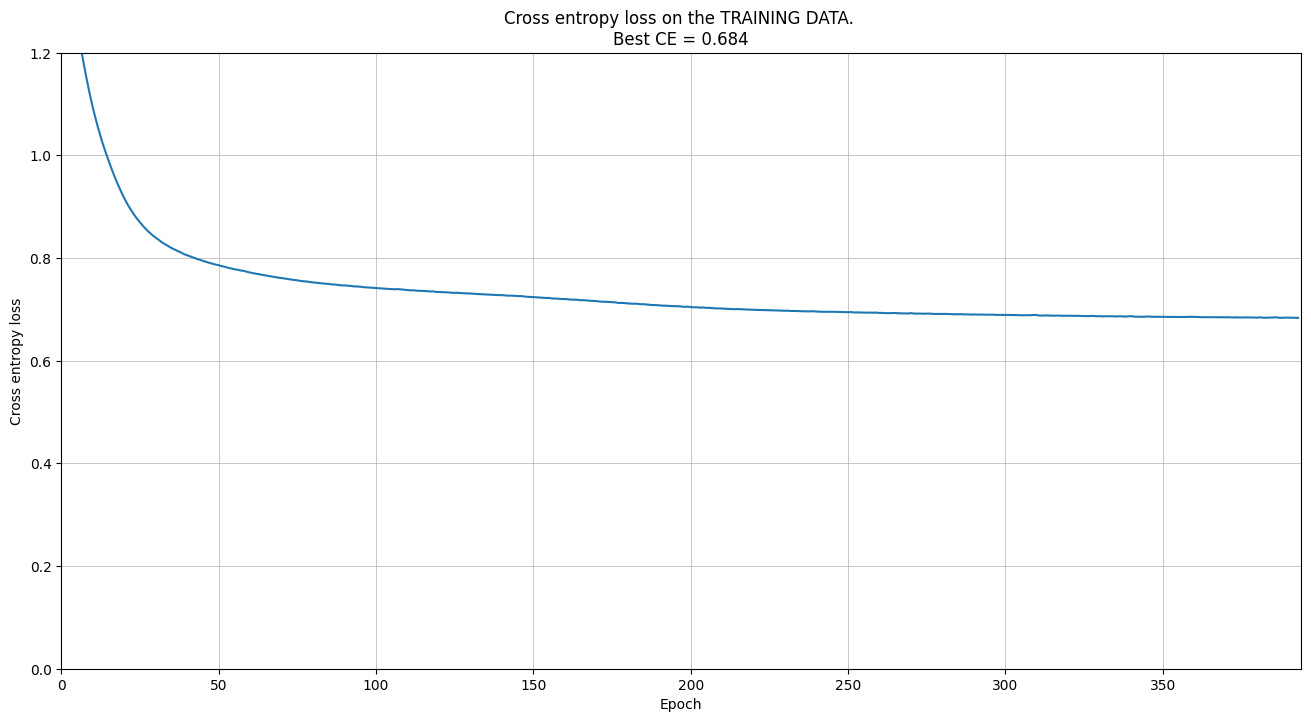

In [113]:
# It is good practice to look at the learning curve, to see how much the model has improved from the initial point,
# and how is has evolved over epochs.
fig, ax = plt.subplots(figsize = (16,8))
plt.plot(mlp.loss_curve_)
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross entropy loss')
ax.grid(True,linewidth = 0.5)
ax.set_ylim(0.0,1.2)
ax.set_xlim(0,mlp.n_iter_)
ax.set_title(f'Cross entropy loss on the TRAINING DATA. \nBest CE = {mlp.loss_:4.3f}')
# The plot illustrates that the training stops when the training loss does no longer improve more that a given tolerance (e.g. 1e-6), or reaches max_iter

`v. Evaluating the model performance` <br>
Machine learning researchers usually evaluate the performance of a classification model using the cross-entropy. A lower cross entrop indicates a better model. In contrast, choice modellers usually look at the Log-likelihood (LL) and the rho-square. A high LL and rho-square indicate a better model. <br>
As there is no standard function that outputs the evaluation metrics of both disciplines, below we create our **own evaluation function**.

In [114]:
# We create an eavluation function that returns key evaluation metrics: LL, LL0, cross_entropy, rho_sq
# To compute these performance metrics, the function takes as inputs:
#   - the predicted probabilities (prob)
#   - the choices (Y)
#   - the availabilities (AV)
def eval_performance(prob,Y,AV):
    
    # Calculate the likelihood of the data given the model
    LL = np.sum(np.log(np.sum(prob*Y,axis=1)))

    # Calculate the Null-loglikelihood
    LL0 = np.sum(np.log(np.divide(1,np.sum(AV,axis=1))))

    # Calculate cross-entropy
    cross_entropy =  -LL/len(AV)
    
    # Calculate the rho_sq
    rho_sq = 1 -(LL/LL0)
    return LL, LL0, cross_entropy, rho_sq

In [115]:
# Let's use our function to evaluate and compare the performance of our MLP on the training and test data sets
eval_train = eval_performance(mlp.predict_proba(X_train),np.transpose([Y_train ==1,Y_train ==2,Y_train ==3, Y_train ==4]), X_train[['av_car','av_bus','av_rail','av_air']])
eval_test  = eval_performance(mlp.predict_proba(X_test), np.transpose([Y_test  ==1,Y_test  ==2,Y_test  ==3, Y_test  ==4]), X_test[['av_car','av_bus','av_rail','av_air']])

# Print the results
print('Model performance of the plain vanilla MLP:')
pd.options.display.float_format = '{:,.2f}'.format
results = pd.DataFrame({'data set':     ['Train','Test'],
                        'LL':           [eval_train[0], eval_test[0]],
                        'LL0':          [eval_train[1], eval_test[1]],
                        'cross_entropy':[eval_train[2], eval_test[2]],
                        'rho_sq':       [eval_train[3], eval_test[3]]})
print(results.T)

Model performance of the plain vanilla MLP:
                      0         1
data set          Train      Test
LL            -2,867.10 -2,037.15
LL0           -4,902.96 -3,293.06
cross_entropy      0.68      0.73
rho_sq             0.42      0.38


To get a sense of how well this plain vanilla MLP performs, below are the same performance metrics for a RUM-MNL model printed (on all data).

In [116]:
print(f'LL\t\t {results_rum_mnl.getGeneralStatistics()["Final log likelihood"][0]:0.2f} \
      \nLL0\t\t {results_rum_mnl.getGeneralStatistics()["Null log likelihood"][0]:0.2f} \
      \ncross_entropy\t {-results_rum_mnl.getGeneralStatistics()["Final log likelihood"][0]/len(dff):0.2f} \
      \nrho_sq\t\t {results_rum_mnl.getGeneralStatistics()["Rho-square for the null model"][0]:0.2f}')

LL		 -5761.74       
LL0		 -8196.02       
cross_entropy	 0.82       
rho_sq		 0.30


**As can be seen, the model fit of the MLP is considerably higher than of the linear-additive RUM-MNL model.**

### ``Exercise 3: Does using more nodes improve the model performance?``
`A` Calculate the number of weights consumed by the current MLP with 10 hidden nodes in 1 hidden layer. <br>
`B` Retrain your model several times with {10,30,60,90} nodes. Report the cross-entropy performance on the train and test data sets.<br>
`C` Does increasing the number of nodes lead to a lower cross-entropy on the train and or test set? What is happening?<br>
`D` Suppose you would have many more choice observations from this survey. Would that enable you to develop a much better model with a cross entropy performance of say <0.10 (on the test set)? Explain your answer. <br>

$\color{green}{\text{Add your answers here}}$

In [117]:
# Add your code here

In [118]:
# ANSWERS
# A)
# B)
# C)
# D)

### `3. Using Early stopping to avoid overfitting`
Early stopping refers to a technique that stops the training of the network when the performance on the test data set no longer improves. Thereby, early stopping avoids the model to overfit the data. It essetially stops the training before the model can overfit.  

In [119]:
# Note this is the same 'plain vanilla' MLP, but now we set early_stopping = True
# A validation_fraction is added. This fraction is the proportion of training data to set aside as validation set for early stopping. This data set is used to determine when to stop. 
# The training stops when the performance on the validation data set does not improve for n_iter_no_change in a row
# We use the MLP with 10 nodes and one hidden layer again.
layers = (10)
n_iter_no_change = 10
mlp_early_st = MLPClassifier(hidden_layer_sizes = layers, solver='adam', learning_rate_init = 0.001, alpha=0, batch_size=250, activation = 'relu', max_iter = 2000, early_stopping=True, n_iter_no_change = n_iter_no_change,validation_fraction = 0.25) 

# Train the MLP using the train data
# Note that we use df.values here. This is due to a small bug in sk-learn. Without .values sk-learn still works, but prompts some warnings
mlp_early_st.fit(X_train.values, Y_train.values)

MLPClassifier(alpha=0, batch_size=250, early_stopping=True,
              hidden_layer_sizes=10, max_iter=2000, validation_fraction=0.25)

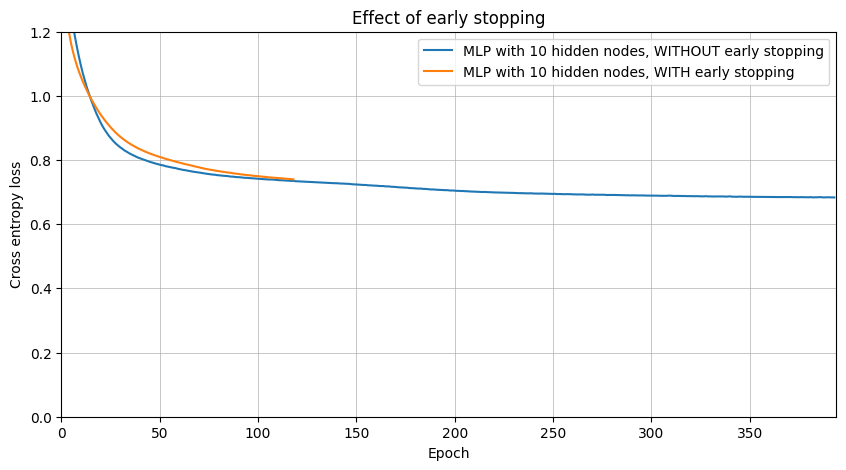

In [120]:
# It is good practice to look at the learning curve, to see how much the model has improved from the initial point,
# and how it has evolved over the epochs.
# The learning curve plot also illustrates well what early stopping does.
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(mlp.loss_curve_,label=f'MLP with {mlp.hidden_layer_sizes} hidden nodes, WITHOUT early stopping')
plt.plot(mlp_early_st.loss_curve_,label=f'MLP with {mlp_early_st.hidden_layer_sizes} hidden nodes, WITH early stopping')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross entropy loss')
ax.grid(True,linewidth = 0.5)
ax.set_ylim(0.0,1.2)
ax.set_xlim(0,mlp.n_iter_)
ax.set_title('Effect of early stopping')
ax.legend()

In [121]:
# Let's use our evaluation function again to evaluate performance of the MLP with early stopping on the training and test data set
eval_train_early_st = eval_performance(mlp_early_st.predict_proba(X_train.values),np.transpose([Y_train ==1,Y_train ==2,Y_train ==3, Y_train ==4]), X_train[['av_car','av_bus','av_rail','av_air']])
eval_test_early_st  = eval_performance(mlp_early_st.predict_proba(X_test.values), np.transpose([Y_test  ==1,Y_test  ==2,Y_test  ==3, Y_test  ==4]), X_test[['av_car','av_bus','av_rail','av_air']])

pd.options.display.float_format = '{:,.2f}'.format
results_early_st = pd.DataFrame({'data set':     ['Train','Test'],
                        'LL':           [eval_train_early_st[0], eval_test_early_st[0]],
                        'LL0':          [eval_train_early_st[1], eval_test_early_st[1]],
                        'cross_entropy':[eval_train_early_st[2], eval_test_early_st[2]],
                        'rho_sq':       [eval_train_early_st[3], eval_test_early_st[3]]})
print(results_early_st.T)

                      0         1
data set          Train      Test
LL            -3,163.56 -2,164.80
LL0           -4,902.96 -3,293.06
cross_entropy      0.75      0.77
rho_sq             0.35      0.34


### ``Exercise 4: Can we overfit with early stopping?``
`A` Did early stopping reduced overfitting? How can you see this from the printed results?<br>
`B` Try if early stoppping also helps to avoid overfitting when using more nodes, e.g. 100, or (50,50) nodes

$\color{green}{\text{Add your answers here}}$

In [122]:
# Add your code here

In [123]:
# ANSWERS
# A)
# B)

### `4. Using k-fold cross validation to evaluate generalisation performance`
k-fold cross validation is commonly used to more accurately **evaluate the generalisation performance** of a given network. It improves a simple train-test split approach in that it systematically cuts the data set in k pieces. k-fold cross validation is especially crucial when tuning hyperparameters (as we will see later).

In [124]:
# Create MLP object (plain vanilla MLP without early stopping)
layers = 10
mlp_cv = MLPClassifier(hidden_layer_sizes = layers, solver='adam', learning_rate_init = 0.001, alpha=0, batch_size=250, activation = 'relu', max_iter = 2000) 

# Create scoring function
# It is necessary to create a scoring function when working with cross_validate of sk-learn
# We set `greater_is_better` to `False` as we are minimising cross entropy loss
logloss = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

# Apply cross_validate, using e.g. 5 folds
# Since we use cross-validation training takes n_folds times longer than using a train-test split
n_folds = 5
cv_results = cross_validate(mlp_cv,dff_scaled[features],Y,cv = n_folds, scoring=logloss,return_train_score=True)

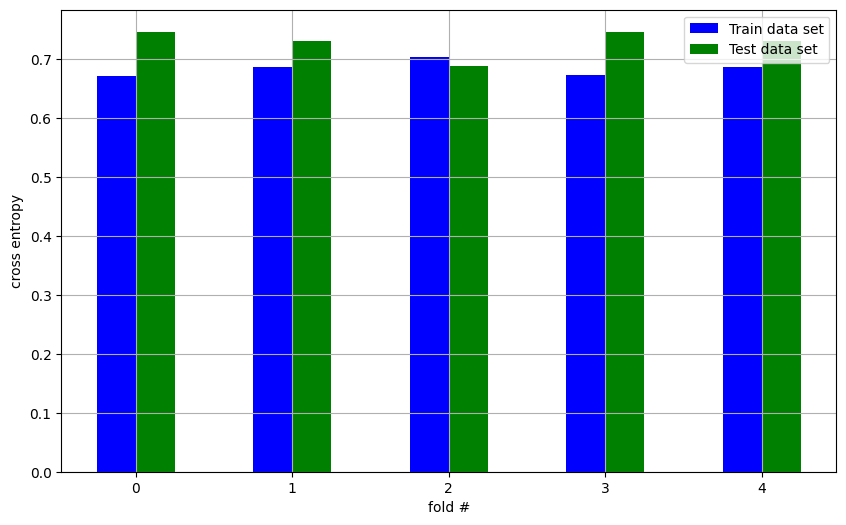

In [125]:
# Plot the train and test performance in a bar plot, for each fold
fig, ax = plt.subplots(figsize=(10, 6))
x_axis = np.arange(n_folds)
ax.bar(x_axis + -0.125, -cv_results['train_score'], color = 'b', width = 0.25,label = 'Train data set')
ax.bar(x_axis +  0.125, -cv_results['test_score'], color = 'g', width = 0.25,label = 'Test data set')
ax.set_xlabel('fold #')
ax.set_ylabel('cross entropy')
ax.grid()
ax.legend()

**Hence, this cross validation analysis supports the finding that a plain vanilla MLP (i.e. without early stopping) only slightly overfits the data**

## `5. Tuning hyperparameter`
When training MLPs (and most other ML models) there are several parameters we can **'tune'** (optimise) to improve the model's performance. The process of doing this is called **hyperparameter tuning**. Hyperparameter tuning can be done manually, but that is unwieldy. The GridSearchCV function in `sk-learn` automates the hyperparemeter tuning process. When tuning the hyperparameters, it is mandatory to use a k-fold cross validation approach. Otherwise, there is a risk of overfitting on the test set *because* the parameters can be tweaked until the estimator performs optimally on the test data set.

In [126]:
# Do not change these lines (they ensure the code runs fast enough on colab and local, by reducing the no. iterations for colab)
try:
    num_iters 
except NameError:
    num_iters = 2000
else:
    num_iters = 250

# Create MLP object (plain vanilla MLP)
mlp_gs = MLPClassifier(activation = 'relu', solver='adam', batch_size=250, max_iter=num_iters)

# Define the hyperparameter search space
# 'hidden_layer_sizes' defines the number of nodes and layers
# 'alpha' governs the L2 regularisation
# 'learning_rate_init' governs the learning rate.
hyperparameter_space = {
    'hidden_layer_sizes': [(10),(10,10),(30,30)],
    'alpha': [0,0.01,1],
    'learning_rate_init': [0.01,0.001,0.0001]}

# Create scoring function
logloss = make_scorer(log_loss, greater_is_better = False, needs_proba = True)

# Create the grid_search object, with using the MLP classifier
folds = 5 # Number of cross validation splits
mlp_gridsearch = GridSearchCV(mlp_gs, hyperparameter_space, n_jobs=-1, cv=folds,scoring = logloss)

In [127]:
# Execute the training/gridsearch
# Note that this is computationally expensive! 
# It may take up to 5 minutes, since 3 x 3 x 3 = 27 models need to be trained, each with 5 folds (=135)
mlp_gridsearch.fit(X_train, Y_train)

/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

GridSearchCV(cv=5, estimator=MLPClassifier(batch_size=250, max_iter=250),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.01, 1],
                         'hidden_layer_sizes': [10, (10, 10), (30, 30)],
                         'learning_rate_init': [0.01, 0.001, 0.0001]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

Save your hyperparameter tuning results, so we only have to do it once.

In [128]:
# Save your model 
filename = 'my_tuned_model.sav'
pickle.dump(mlp_gridsearch, open(filename,'wb'))

In [129]:
# Load your model (if you have a saved model)
# mlp_gridsearch = pickle.load(open(filename,'rb'))

Visualise the hyperparameter tuning results

/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sandervancranenburgh/.pyenv/versions/3.11.5/envs/sen1221env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Best hyperparameters found:	 {'alpha': 1, 'hidden_layer_sizes': (30, 30), 'learning_rate_init': 0.001}
Best model performance:		 0.7358722730143692


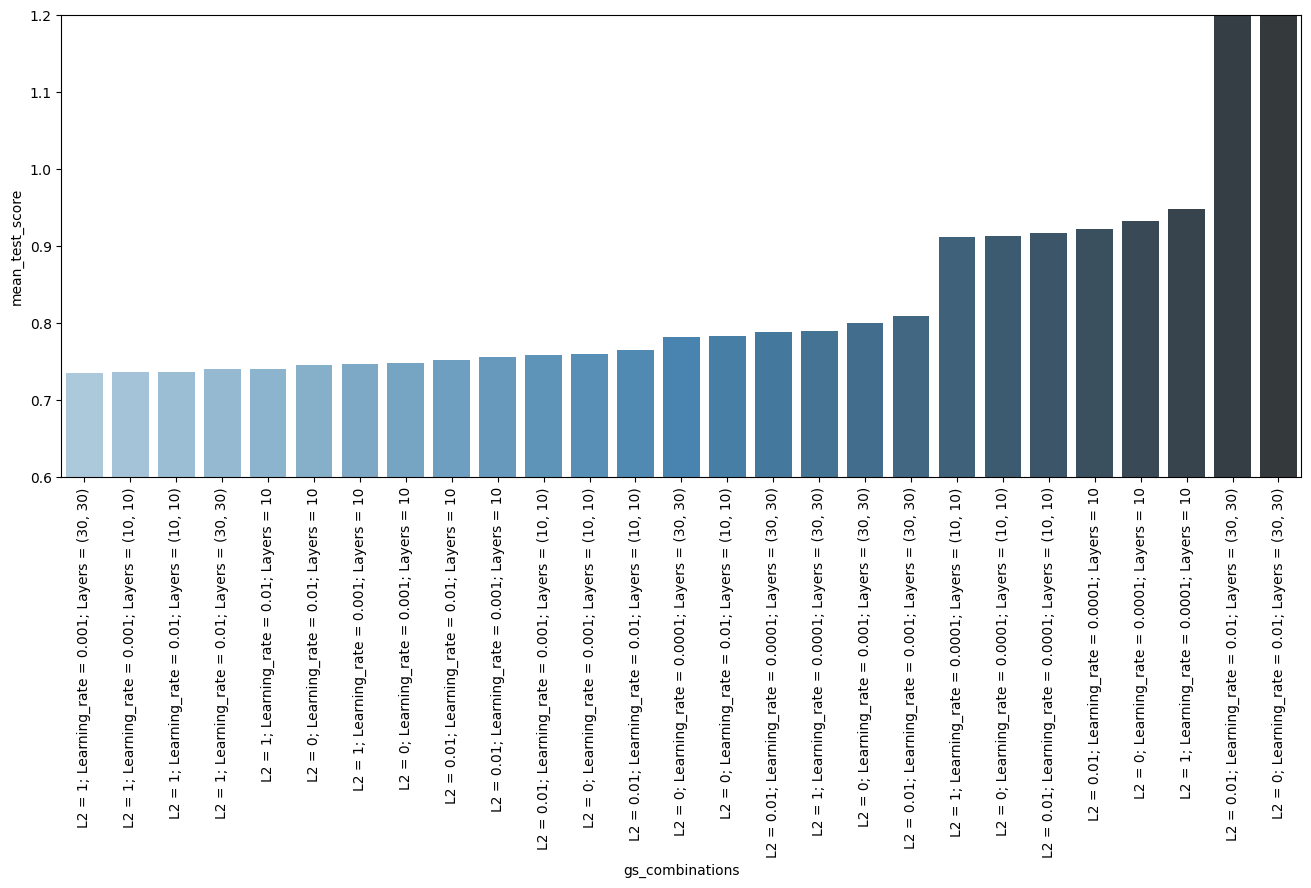

In [130]:
# Collect results into a new pandas dataframe
df_gridsearch = pd.DataFrame.from_dict(mlp_gridsearch.cv_results_)
    
# Add new column with a label for the hyperparameter combinations %% NOT SURE IF THIS IS BET WAY TO DO THIS IN PYTHON   
df_gridsearch['gs_combinations'] = 'L2 = '+ df_gridsearch['param_alpha'].astype('str') + '; Learning_rate = '+ df_gridsearch['param_learning_rate_init'].astype('str') + '; Layers = ' + df_gridsearch['param_hidden_layer_sizes'].astype('str')
df_gridsearch = df_gridsearch.sort_values('rank_test_score')

# Visualise deviation in performance across hyper parameter settings
plt.figure(figsize = (16,6))
ax = sns.barplot(x = df_gridsearch.gs_combinations,y=-df_gridsearch.mean_test_score,palette="Blues_d",)
ax.set_ylim(0.6,1.2)
plt.xticks(rotation=90)

print('Best hyperparameters found:\t', mlp_gridsearch.best_params_)
print('Best model performance:\t\t', -mlp_gridsearch.best_score_)

### ``Exercise 5: Hyperparameter tuning``
`A` Compare the performance of the hypertuned model with the plain vanilla MLP. Has the generalisation performance improved? How much?<br>
`B` What hyperparameter turns out to be particularly impactful on the model performance?<br>
`C` Can you think of reasons why this could be the case?

$\color{green}{\text{Add your answers here}}$

In [131]:
# Add your code here

In [132]:
# ANSWERS
# A)
# B)
# C)

**(Re)Training the model with optimised hyperparameters**<br> 
After completing hypertuning, you know the optimal hyperparameters. <br>
Therefore, after hypertuning we always retrain the model using the optimised hyperparameters.

In [133]:
# Create a new mlp object using the optimised hyperparameters, just using the train/test split
layers = mlp_gridsearch.best_params_['hidden_layer_sizes']
lr = mlp_gridsearch.best_params_['learning_rate_init']
alpha = mlp_gridsearch.best_params_['alpha']
mlp_gs = MLPClassifier(hidden_layer_sizes = layers, solver='adam', learning_rate_init = lr, alpha=alpha, batch_size=250, activation = 'tanh', max_iter = 2000) 

# Train the model
mlp_gs.fit(X_train,Y_train)

MLPClassifier(activation='tanh', alpha=1, batch_size=250,
              hidden_layer_sizes=(30, 30), max_iter=2000)

In [134]:
# Let's also evaluate performance on the hypertuned model using our evaluation function
# Note we use the full data here
eval_gridsearch = eval_performance(mlp_gs.predict_proba(dff_scaled[features]),np.transpose([Y ==1,Y ==2,Y ==3, Y==4]), dff_scaled[['av_car','av_bus','av_rail','av_air']])

pd.options.display.float_format = '{:,.2f}'.format
results_clf = pd.DataFrame({'data set': ['All data'],
                        'LL':           [eval_gridsearch[0]],
                        'LL0':          [eval_gridsearch[1]],
                        'cross_entropy':[eval_gridsearch[2]],
                        'rho_sq':       [eval_gridsearch[3]]})
print(results_clf.T)

                      0
data set       All data
LL            -4,863.96
LL0           -8,196.02
cross_entropy      0.69
rho_sq             0.41


### `6. Evaluating and comparing performances across trained models`

To evaluate the performance of a wide range is metrics are available, beyond generalisation performance.<br>
Here, we look at:<br>
i. Confusion matrix<br>
ii. Precision, Recall, and F1-score<br>
iii. Matthew's correlation coefficient

**i) Confusion matrix**<br>
Confusion matrices shows counts from predicted and actual outcomes. The counts on the diagonal are correctly classified outcomes (the model predictions and the ground true are the same). The counts on the off diagonal elements are the misclassified outcomes. Hence, the best classifier will have a confusion matrix with only diagonal elements and the rest of the elements set to zero.<br>
We compare the **MLP with early stopping** against the **MLP with hyperparameter tuning**.   

In [135]:
biodata_sim = db.Database('biodata_test_sim', dff.iloc[test_indices,:])

prob_car = models.logit(V, AV, 1)
prob_bus = models.logit(V, AV, 2)
prob_air = models.logit(V, AV, 3)
prob_rail = models.logit(V, AV, 4)

simulate = {
    'Prob. car': prob_car,
    'Prob. bus': prob_bus,
    'Prob. air': prob_air,
    'Prob. rail': prob_rail}

biogeme_sim = bio.BIOGEME(biodata_sim, simulate)
simulated_values = biogeme_sim.simulate(results_rum_mnl.getBetaValues())
Y_mnl = np.argmax(simulated_values.values,axis=1)+1

The chosen alternative [`1.0`] is not available for the following observations (rownumber[choice]): 4[1.0]-14[1.0]-19[1.0]-21[1.0]-23[1.0]-27[1.0]-28[1.0]-32[1.0]-33[1.0]-37[1.0]-46[1.0]-48[1.0]-51[1....
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 8[2.0]-17[2.0]-34[2.0]-42[2.0]-51[2.0]-60[2.0]-69[2.0]-102[2.0]-109[2.0]-131[2.0]-139[2.0]-164[2.0]-...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 1[3.0]-4[3.0]-6[3.0]-7[3.0]-10[3.0]-15[3.0]-20[3.0]-25[3.0]-26[3.0]-27[3.0]-30[3.0]-39[3.0]-41[3.0]-...
The chosen alternative [`4.0`] is not available for the following observations (rownumber[choice]): 3[4.0]-14[4.0]-21[4.0]-23[4.0]-31[4.0]-37[4.0]-47[4.0]-70[4.0]-84[4.0]-90[4.0]-103[4.0]-114[4.0]-124...
The chosen alternative [`1.0`] is not available for the following observations (rownumber[choice]): 4[1.0]-14[1.0]-19[1.0]-21[1.0]-23[1.0]-27[1.0]-28[1.0]-32[1.0]-33[1.0]-37[1.0]-46[1.

Text(0.5, 1.0, 'MLP with (30, 30) nodes \n hyperparameters tuned')

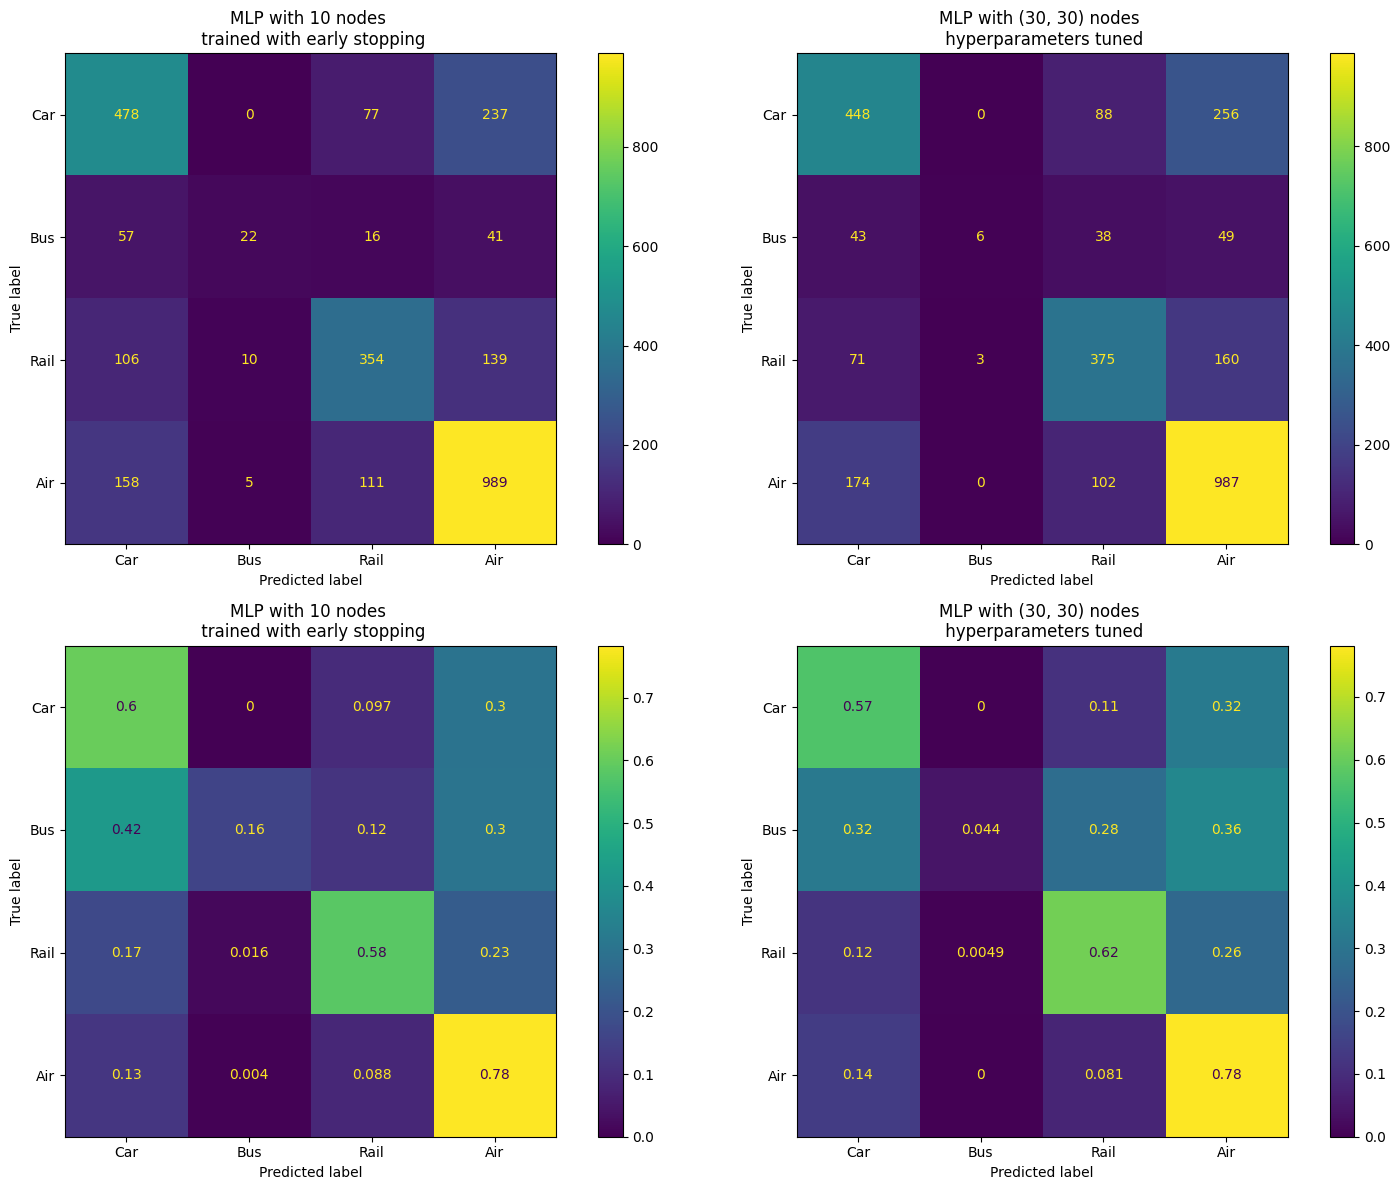

In [136]:
# Predict the choices for the test data set, using the MLP trained with early stopping and MLP with hyperparameters tuned
Y_pred_early_st  = mlp_early_st.predict(X_test.values)  # 0/1 predictions of MLP trained with early stopping
Y_pred_gs = Y_mnl # mlp_gs.predict(X_test)                      # 0/1 predictions of MLP with hyperparameters tuned

# Show the confusion matrices, to compare the hyperparameter tuned network with the early stopping network
fig, ax = plt.subplots(2,2,figsize = (16,12))
fig.set_tight_layout(True)
ylabels = ['Car', 'Bus', 'Rail', 'Air']
cm1 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_early_st, display_labels = ylabels, normalize=None,  ax=ax[(0,0)])
cm2 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_early_st, display_labels = ylabels, normalize='true',ax=ax[(1,0)])
cm3 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_gs, display_labels = ylabels, normalize=None,  ax=ax[(0,1)])
cm4 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_gs, display_labels = ylabels, normalize='true',ax=ax[(1,1)])

# Add titles
cm1.ax_.set_title(f'MLP with {mlp_early_st.hidden_layer_sizes} nodes \n trained with early stopping')
cm2.ax_.set_title(f'MLP with {mlp_early_st.hidden_layer_sizes} nodes \n trained with early stopping')
cm3.ax_.set_title(f'MLP with {mlp_gs.hidden_layer_sizes} nodes \n hyperparameters tuned')
cm4.ax_.set_title(f'MLP with {mlp_gs.hidden_layer_sizes} nodes \n hyperparameters tuned')

### ``Exercise 6: Model accuracy``
Accuracy is defined as the true positives over the total number of cases.<br>
`A` Manually compute the prediction accuracy of the model with early stopping and the model with hyperparameter tuning<br>
`B` For which class (Train/SM/Car) does the hyperparameter tuning improves the prediction accuracy most?<br>

$\color{green}{\text{Add your answers here}}$

In [137]:
# Add your code here

In [138]:
# ANSWERS
# A)
# B)

**ii) Precision, Recall, and F1**<br>
Looking at the confusion matrices, the improvements in prediction accuracy due to the hyperparameter tuning may not seem very impressive. However, one should keep in mind that 0/1 predictions are sensitive to class imbalances, which are present in these data. Moreover, accuracy can be a misleading metric for imbalanced data sets. A naive model that would simply always predict "SM" will already do quite good.

To assess the model performance in more depth, we thus must look at the predictions at the level of the classes.<br> 
Next, we compute Precision, Recall, and F1 score.<br>
* **Precision** Tells you what fraction of predictions for a given class are actually of that class.<br>
* **Recall** Tells what fraction of all observations belonging to a given class are correctly predicted as such by the model. Recall is also known as True Positive Rate (TPR), Sensitivity, Probability of Detection. <br>
* **F1 score** combines precision and recall into a single measure. Mathematically it’s the harmonic mean of precision and recall. It can be calculated as follows: <br>

In [139]:
# To calculate the precision, recal and f1 score we conveniently use sk-learn's 'classification_report' functionality
print('Classification report for plain vanilla MLP with early stopping\n',classification_report(Y_test,Y_pred_early_st, target_names= ylabels))
print('\nClassification report for plain vanilla MLP with hyperparameters tuned\n',classification_report(Y_test,Y_pred_gs, target_names= ylabels))

Classification report for plain vanilla MLP with early stopping
               precision    recall  f1-score   support

         Car       0.60      0.60      0.60       792
         Bus       0.59      0.16      0.25       136
        Rail       0.63      0.58      0.61       609
         Air       0.70      0.78      0.74      1263

    accuracy                           0.66      2800
   macro avg       0.63      0.53      0.55      2800
weighted avg       0.65      0.66      0.65      2800


Classification report for plain vanilla MLP with hyperparameters tuned
               precision    recall  f1-score   support

         Car       0.61      0.57      0.59       792
         Bus       0.67      0.04      0.08       136
        Rail       0.62      0.62      0.62       609
         Air       0.68      0.78      0.73      1263

    accuracy                           0.65      2800
   macro avg       0.64      0.50      0.50      2800
weighted avg       0.65      0.65      0.63    

**iii) Matthew's correlation coefficient**<br>
Another commonly used metric to evaluate the prediction performance while accounting for imbalances in the data set is  matthews correlation coefficient. Matthews Correlation Coefficient (MCC) is generally regarded as being one of the best measures to describe the confusion matrix of true and false positives and negatives by a **single number**, even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

In [140]:
# Taking into account the imbalances of the data
print(f'Matthews correlation coefficient for plain Vanilla MLP with early stopping:\t {matthews_corrcoef(Y_test, Y_pred_early_st):4.3f}')
print(f'Matthews correlation coefficient for plain Vanilla MLP with hypertuning:\t {matthews_corrcoef(Y_test, Y_pred_gs):4.3f}')

Matthews correlation coefficient for plain Vanilla MLP with early stopping:	 0.475
Matthews correlation coefficient for plain Vanilla MLP with hypertuning:	 0.458


### ``Exercise 7: Model precision, recall, f1 and Matthew's correlation coefficent``
`A` Compare and interpret the results from the classifications reports between the early stopping and hypertuned model.<br>
`B` Compare and interpret the results from Matthews correlation coefficient between the early stopping and hypertuned model.

$\color{green}{\text{Add your answers here}}$

In [141]:
# Add your code here

In [142]:
# ANSWERS
# A)
# B)